# Audio Recoginition 4C16/5C16 Project

## Audio Content & Gender Classification

#### About the dataset

The dataset consists of 25k audio tracks. Each of the audio track records the waveform of an audio recording of a human reading out digit (ie. from 0-9). Your task is to train two classification neural networks that **identify the digit** that has been uttered and **identify the gender**.

The dataset has already been prepared to numpy files and is in the 'dataset' directory and is of the following structure:

- *dataset/*
    - *input.npy*
    - *gender.npy*
    - *digit.npy*

The *input.npy* has a shape of (25000, 8000) which indicates 25000 waveforms and 8000 samples from each waveform. Each waveform is normalised with 1 second duration and 8 kHz sampling frequnecy. The *gender.npy* and *digit.npy* files contains the correspondent target information of the 25000 waveforms in the same order.



In [1]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/4c16-labs/code/lab-07/

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
[Errno 2] No such file or directory: '/content/drive/MyDrive/4c16-labs/code/lab-07/'
/content


In [ ]:
# Download the dataset
!curl --create-dirs -o C:/Users/lic9/Desktop/pynb/data/audiowavform-dataset.tar.xz https://tcddeeplearning.blob.core.windows.net/deeplearning202324/audiowavform-dataset.tar.xz
# Extract the dataset
!mkdir C:/Users/lic9/Desktop/pynb/data/audiowavform
!tar -xvf C:/Users/lic9/Desktop/pynb/data/audiowavform-dataset.tar.xz -C C:/Users/lic9/Desktop/pynb/data/audiowavform

# Dataset location: /home/tcd/data/audiowavform/public

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed

  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
 10  108M   10 11.0M    0     0  20.3M      0  0:00:05 --:--:--  0:00:05 20.3M
 37  108M   37 40.2M    0     0  26.1M      0  0:00:04  0:00:01  0:00:03 26.1M
 66  108M   66 72.0M    0     0  28.3M      0  0:00:03  0:00:02  0:00:01 28.3M
 95  108M   95  103M    0     0  29.1M      0  0:00:03  0:00:03 --:--:-- 29.1M
100  108M  100  108M    0     0  28.3M      0  0:00:03  0:00:03 --:--:-- 28.3M
The syntax of the command is incorrect.


In [54]:
import os
import scipy
import librosa
import numpy as np
import matplotlib.pyplot as plt
import tensorflow.keras as keras
from skimage.transform import resize

import tensorflow as tf



from IPython.display import clear_output

from matplotlib.ticker import MaxNLocator

import sklearn as skl

from sklearn import datasets, linear_model
from sklearn.model_selection import cross_val_score

In [55]:
# loading the datasets in memory

dataset_path = 'C:/Users/lic9/Desktop/pynb/data/audiowavform/public'

# xtrain  : numpy array of size n x 8000 which contains the waveforms for each of the 25k audio files.
x = np.load(f'{dataset_path}/xtrain.npy')

# y_num   : numpy array of size n x 10 which contains the digits (as one-hot encoding of the 10 categories) for each of the 25k audio files.
y_num = np.argmax(np.load(f'{dataset_path}/ytrain_num.npy'), axis=-1)

# y_gender: numpy array of size n x 2 which contains the gender (as one-hot encoding of the 2 categories) for each of the 25k audio files.
y_gender = np.argmax(np.load(f'{dataset_path}/ytrain_gender.npy'), axis=-1)


print("Array shape:\n", y_num.shape)

print(y_num[1])

Array shape:
 (25000,)
3


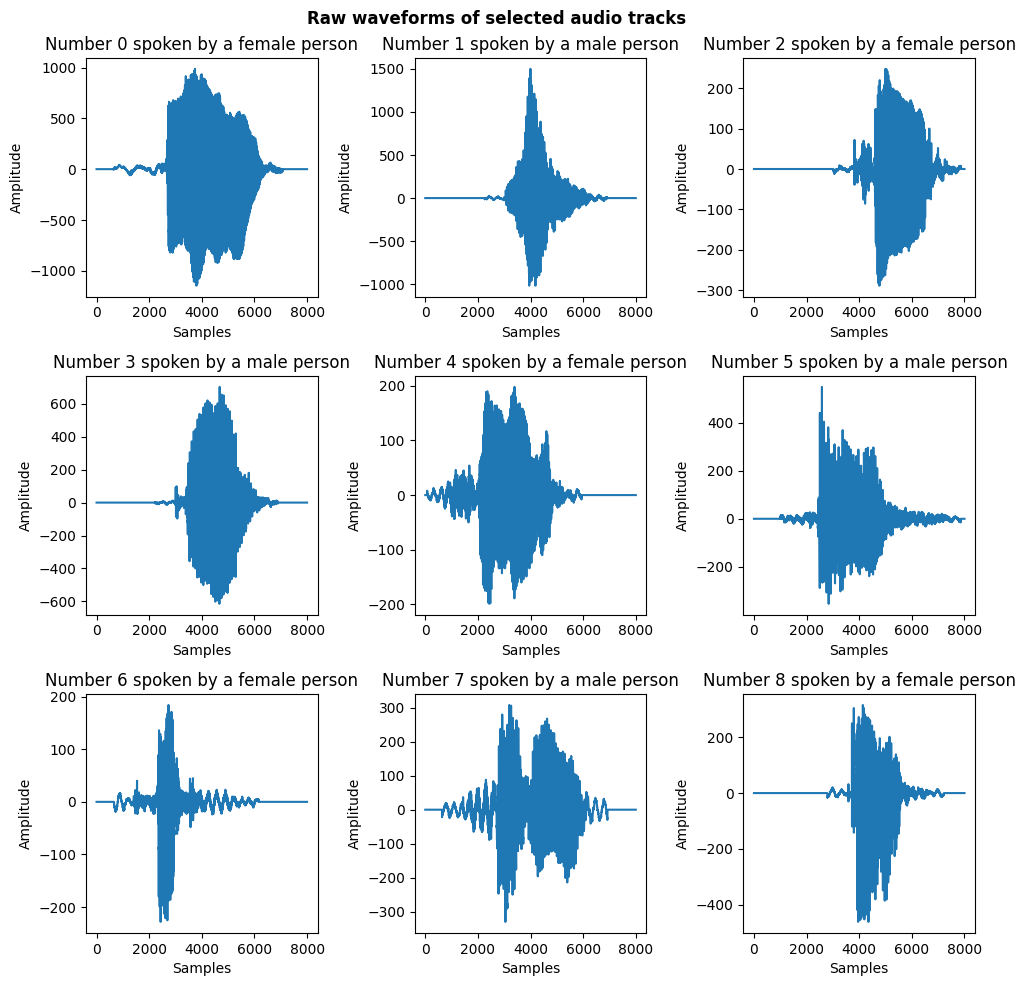

In [56]:
# let's look at the data.
# The code below takes the same samples for the 0-9 digits by females and males
# and display the waveforms asscociated with each of the selected audio files.


gender_ = 0
fig1, axs1 = plt.subplots(3, 3, figsize=(10, 10))

# iterating through the digits 0-9
for i, ax in zip(range(0, 10), axs1.ravel()):
    # we want to show some variety in the genders, so we are alternating genders
    # and seeking the next sample with correct gender/digit
    gender_ = 1 - gender_
    if len(np.intersect1d(np.where(y_num == i)[0], np.where(y_gender == gender_)[0])) == 0:
        continue
    index_to_show = np.intersect1d(np.where(y_num == i)[0], np.where(y_gender == gender_)[0])[0]

    # extracting the waveform and the labels
    audio_track = x[index_to_show]
    num_speak = y_num[index_to_show]
    gender_spoke = y_gender[index_to_show]
    gender_spoke = 'male' if gender_spoke == 0 else 'female'

    # plotting
    ax.plot(
        list(range(1, 8000 + 1, 1)),
        audio_track,
    )
    ax.set_ylabel('Amplitude')
    ax.set_xlabel('Samples')
    ax.set_title(f'Number {num_speak} spoken by a {gender_spoke} person')

fig1.suptitle(
    'Raw waveforms of selected audio tracks',
    fontsize=12,
    weight='bold',
)
fig1.tight_layout(pad=1)

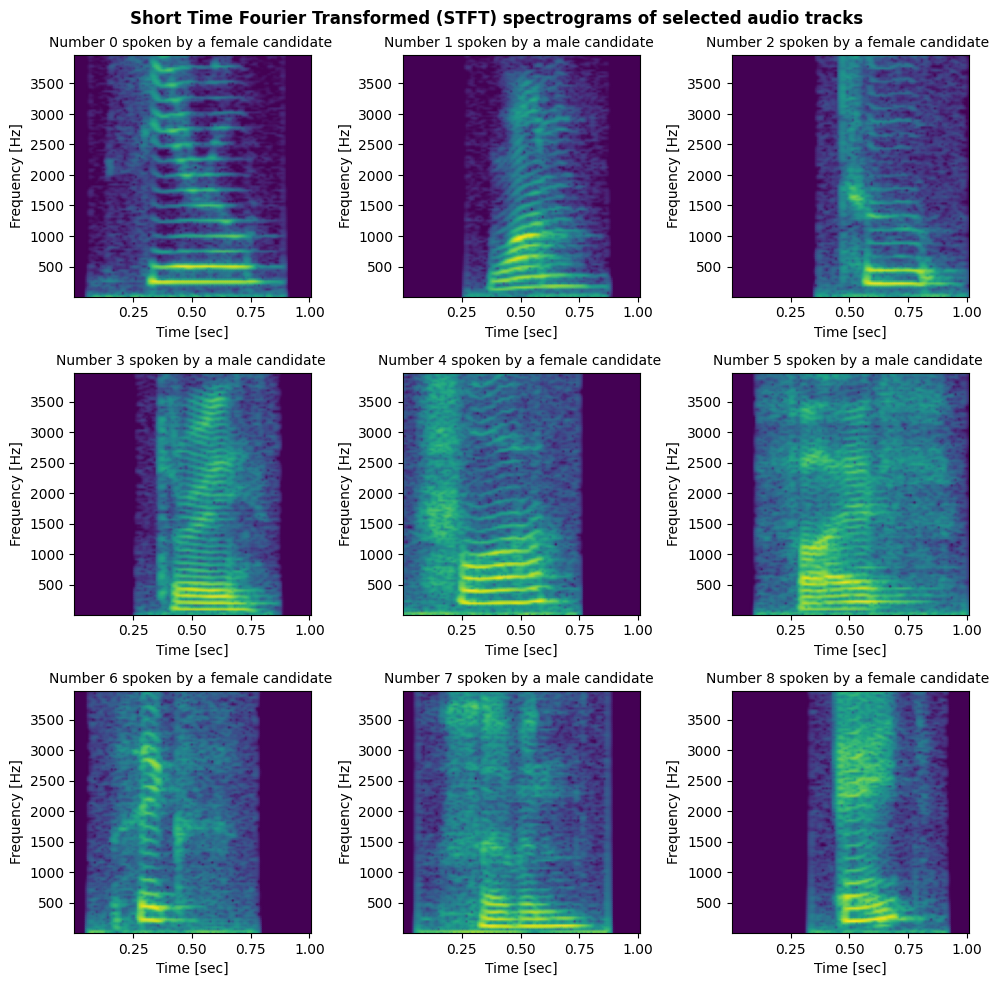

In [57]:
# The code below takes the same samples for the 0-9 digits by females and males as in previous cell
# and display the spectrograms asscociated with the waveforms.

gender_ = 0
fig2, axs2 = plt.subplots(3, 3, figsize=(10, 10))

# iterating through the digits 0-9
for i, ax in zip(range(0, 10), axs2.ravel()):
    # we want to show different genders in this preview, so alternating genders
    gender_ = 1 - gender_
    # find the next sample with correct gender and digit
    if len(np.intersect1d(np.where(y_num == i)[0], np.where(y_gender == gender_)[0])) == 0:
        continue
    index_to_show = np.intersect1d(np.where(y_num == i)[0], np.where(y_gender == gender_)[0])[0]
    audio_track = x[index_to_show]
    num_speak = y_num[index_to_show]
    gender_spoke = y_gender[index_to_show]
    gender_spoke = 'male' if gender_spoke == 0 else 'female'
    # the spectrogram is computed through the use of the Short Time Fourier Transform (STFT)
    # see https://en.wikipedia.org/wiki/Short-time_Fourier_transform
    f, t, Zxx = scipy.signal.stft(audio_track, 8000, nperseg=455, noverlap=393, window='hann')
    Zxx_ = np.abs(Zxx[0:227, 2:-1])
    Zxx_ = np.atleast_3d(Zxx_).transpose(2,0,1)
    # after the STFT, the spectrogram is simply computed by taking the amplitude of the Fourier coefficients.
    Zxx_ = librosa.amplitude_to_db(Zxx_, ref=np.max)

    #
    f_, t_ = f[:227], t[:227]

    # to be able to fit everything in memory, we'll resize the spectrogram to images of size 128x128
    # this is not strictly necessary here, but when you try to load the entire dataset in memory, that will be
    # useful.
    f_ = resize(f_, (128, ))
    t_ = resize(t_, (128, ))
    Zxx_ = resize(Zxx_, (1, 128, 128))

    ax.set_title(f'Number {num_speak} spoken by a {gender_spoke} candidate ', fontsize=10)
    ax.pcolormesh(t_, f_, Zxx_[0, :, :], shading='gouraud')
    ax.set_ylabel('Frequency [Hz]')
    ax.set_xlabel('Time [sec]')

fig2.suptitle(
    'Short Time Fourier Transformed (STFT) spectrograms of selected audio tracks',
    fontsize=12,
    weight='bold',
)
fig2.tight_layout(pad=1)

In [58]:
# our usual useful functions

class PlotLossAccuracy(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.i = 0
        self.x = []
        self.acc = []
        self.losses = []
        self.val_losses = []
        self.val_acc = []
        self.logs = []

    def on_epoch_end(self, epoch, logs={}):

        self.logs.append(logs)
        self.x.append(int(self.i))
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        self.acc.append(logs.get('accuracy'))
        self.val_acc.append(logs.get('val_accuracy'))

        self.i += 1

        clear_output(wait=True)
        plt.figure(figsize=(16, 6))
        plt.plot([1, 2])
        plt.subplot(121)
        plt.plot(self.x, self.losses, label="train loss")
        plt.plot(self.x, self.val_losses, label="validation loss")
        plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))
        plt.ylabel('loss')
        plt.xlabel('epoch')
        plt.title('Model Loss')
        plt.legend()
        plt.subplot(122)
        plt.plot(self.x, self.acc, label="training accuracy")
        plt.plot(self.x, self.val_acc, label="validation accuracy")
        plt.legend()
        plt.ylabel('accuracy')
        plt.xlabel('epoch')
        plt.title('Model Accuracy')
        plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))
        plt.show();


def save_model_to_disk(model, filename_base):
    # save model and weights (don't change the filenames)
    model_json = model.to_json()
    with open(filename_base + ".json", "w") as json_file:
        json_file.write(model_json)
    # serialize weights to HDF5
    model.save_weights(f"{filename_base}.h5")
    print(f"Saved model to {filename_base}.json and weights to {filename_base}.h5")

### The problem

You have two tasks:

1. Train two neural nets taking in _raw waveforms_ and predicting either the digit or the gender. The input waveform should be treated as an 1-dimentional-list with a shape of (8000, 1). Individual models should be trained for each task listed below:

  - Task 1A. **Classification of Gender**: the output is a keras catergorised vector that has a shape of (2, 1). For example, [0, 1] indicates class 2 which represents a waveform from a female candidate.
  - Task 1B. **Classification of Spoken Number**: the output is a keras categorised vector that has a shape of (10, 1). For example, [0, 0, 1, 0, 0, 0, 0, 0, 0, 0] indicates class 3 which represents a waveform of spoken number 2.

2. Train the neural nets, this time taking the spectrograms as an input. This preprocessing step is commonly considered as a good embedding for representing the audio signal. The spectrograms should be standardised (through cropping) with a shape of [128, 128, 1] (see visualisation sample code above).

  - Task 2A. **Classification of Gender**: the output is a keras categorised vector that has a shape of (2, 1). For example, [0, 1] indicates class 2 which represents a waveform from a female candidate.
  - Task 2B. **Classification of Spoken Number**: the output is a keras categorised vector that has a shape of (10, 1). For example, [0, 0, 1, 0, 0, 0, 0, 0, 0, 0] indicates class 3 which represents a waveform of spoken number 2.

---

**IMPORTANT**

For Task 1A, your model should be saved and submitted with the name: **'waveform_gender_model'**

For Task 1B, your model should be saved and submitted with the name: **'waveform_digit_model'**

For Task 2A, your model should be saved and submitted with the name: **'spectrogram_gender_model'**

For Task 2B, your model should be saved and submitted with the name: **'spectrogram_digit_model'**


In [59]:
# Hints:
#
# Keep track of the shape of your datasets.
#   For Task 1, inputs should be a collection of waveforms of size [25000 x 8000 x 1].
#   For Task 2, inputs should be a collection of spectrograms transformed from the loaded
#               waveforms, with size of [25000 x 128 x 128 x 1].
#
#   For both classificaition tasks, output should be a collection of lists of binary number,
#               with size of [25000 x n_classes x 1].
#
#     * For spectrogram classification tasks, refer to the sample code in
#           this jupyter notebook to understand the methods of transformation.
#
#     * For spectrogram classification tasks, you may need to install the python library
#           'librosa', through the following command line:
#           pip install librosa
#
#     * pay attention to the learning rate scheduling.
#     * You may also think of using pre-trained networks with fine-tuning.


In [60]:
# Data Split


X = x
Y = y_gender
X_train, X_validation, Y_train, Y_validation = skl.model_selection.train_test_split(X, Y, test_size=.1)

print("Array shape:\n", X_train.shape)
print("Array shape:\n", Y_train.shape)
print("Array shape:\n", X_validation.shape)
print("Array shape:\n", Y_validation.shape)



Array shape:
 (22500, 8000)
Array shape:
 (22500,)
Array shape:
 (2500, 8000)
Array shape:
 (2500,)


In [63]:
# Task 1A: Gender Classisation on Waveforms

# Construct your neural networks here

#model_1A = # Figure this out
#save_model_to_disk(model_1A, 'waveform_gender_model')

# model from keras demo

SAMPLING_RATE = 8000
CLASS_NUMS = 2;


def residual_block(x, filters, conv_num=3, activation="relu"):
    # Shortcut
    s = keras.layers.Conv1D(filters, 1, padding="same")(x)
    for i in range(conv_num - 1):
        x = keras.layers.Conv1D(filters, 3, padding="same")(x)
        x = keras.layers.Activation(activation)(x)
    x = keras.layers.Conv1D(filters, 3, padding="same")(x)
    x = keras.layers.Add()([x, s])
    x = keras.layers.Activation(activation)(x)
    return keras.layers.MaxPool1D(pool_size=2, strides=2)(x)


def build_model(input_shape, num_classes):
    inputs = keras.layers.Input(shape=input_shape, name="input")

    x = residual_block(inputs, 8, 2)
    x = residual_block(x, 16, 2)
    x = residual_block(x, 32, 3)
    x = residual_block(x, 64, 3)
    x = residual_block(x, 64, 3)

    x = keras.layers.AveragePooling1D(pool_size=3, strides=3)(x)
    x = keras.layers.Flatten()(x)
    x = keras.layers.Dense(32, activation="relu")(x)
    x = keras.layers.Dense(16, activation="relu")(x)

    #origin_outputs = keras.layers.Dense(num_classes, activation="softmax", name="output")(x)

    #outputs = keras.layers.Reshape((2, 1))(origin_outputs)

    outputs = keras.layers.Dense(num_classes, activation="softmax", name="output")(x)

    return keras.models.Model(inputs=inputs, outputs=outputs)


#model = build_model((SAMPLING_RATE // 2, 1), len(class_names))
model_1A = build_model((SAMPLING_RATE , 1), CLASS_NUMS)


model_1A.summary()

# Compile the model using Adam's default learning rate
model_1A.compile(
    optimizer="Adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"]
)

# Add callbacks:
# 'EarlyStopping' to stop training when the model is not enhancing anymore
# 'ModelCheckPoint' to always keep the model that has the best val_accuracy
#model_save_filename = "model.h5"

# earlystopping_cb = keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)
# mdlcheckpoint_cb = keras.callbacks.ModelCheckpoint(
#     model_save_filename, monitor="val_accuracy", save_best_only=True
# )




Model: "model_14"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input (InputLayer)             [(None, 8000, 1)]    0           []                               
                                                                                                  
 conv1d_91 (Conv1D)             (None, 8000, 8)      32          ['input[0][0]']                  
                                                                                                  
 activation_65 (Activation)     (None, 8000, 8)      0           ['conv1d_91[0][0]']              
                                                                                                  
 conv1d_92 (Conv1D)             (None, 8000, 8)      200         ['activation_65[0][0]']          
                                                                                           

 activation_76 (Activation)     (None, 500, 64)      0           ['conv1d_106[0][0]']             
                                                                                                  
 conv1d_107 (Conv1D)            (None, 500, 64)      12352       ['activation_76[0][0]']          
                                                                                                  
 conv1d_104 (Conv1D)            (None, 500, 64)      4160        ['max_pooling1d_28[0][0]']       
                                                                                                  
 add_29 (Add)                   (None, 500, 64)      0           ['conv1d_107[0][0]',             
                                                                  'conv1d_104[0][0]']             
                                                                                                  
 activation_77 (Activation)     (None, 500, 64)      0           ['add_29[0][0]']                 
          

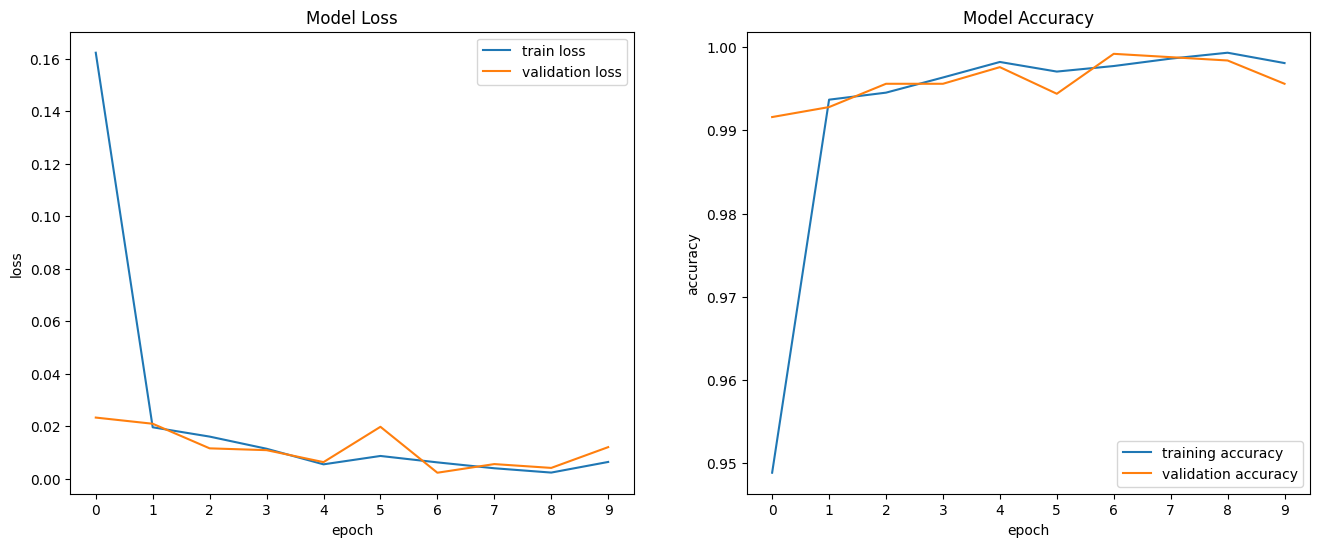

225/225 [==============================] - 10s 46ms/step - loss: 0.0065 - accuracy: 0.9981 - val_loss: 0.0121 - val_accuracy: 0.9956


In [64]:
# model training

num_epochs = 10

# Create an instance of our callback functions class, to plot our loss function and accuracy with each epoch.
pltCallBack = PlotLossAccuracy()

# Run the training.
model_1A.fit(X_train, Y_train,
          batch_size=100, epochs=num_epochs,
          validation_data=(X_validation, Y_validation),
          callbacks=[pltCallBack])

In [65]:
save_model_to_disk(model_1A, 'waveform_gender_model')

Saved model to waveform_gender_model.json and weights to waveform_gender_model.h5


In [69]:
# Data Split
X = x
Y = y_num
X_train, X_validation, Y_train, Y_validation = skl.model_selection.train_test_split(X, Y, test_size=.1)

In [70]:
SAMPLING_RATE = 8000
CLASS_NUMS = 10;


def residual_block(x, filters, conv_num=3, activation="relu"):
    # Shortcut
    s = keras.layers.Conv1D(filters, 1, padding="same")(x)
    for i in range(conv_num - 1):
        x = keras.layers.Conv1D(filters, 3, padding="same")(x)
        x = keras.layers.Activation(activation)(x)
    x = keras.layers.Conv1D(filters, 3, padding="same")(x)
    x = keras.layers.Add()([x, s])
    x = keras.layers.Activation(activation)(x)
    return keras.layers.MaxPool1D(pool_size=2, strides=2)(x)


def build_model(input_shape, num_classes):
    inputs = keras.layers.Input(shape=input_shape, name="input")

    x = residual_block(inputs, 8, 2)
    x = residual_block(x, 16, 2)
    x = residual_block(x, 32, 3)
    x = residual_block(x, 64, 3)
    x = residual_block(x, 64, 3)

    x = keras.layers.AveragePooling1D(pool_size=3, strides=3)(x)
    x = keras.layers.Flatten()(x)
    x = keras.layers.Dense(32, activation="relu")(x)
    x = keras.layers.Dense(16, activation="relu")(x)

    outputs = keras.layers.Dense(num_classes, activation="softmax", name="output")(x)

    return keras.models.Model(inputs=inputs, outputs=outputs)

model_1B = build_model((SAMPLING_RATE , 1), CLASS_NUMS)


model_1B.summary()


model_1B.compile(
    optimizer="Adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"]
)

Model: "model_17"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input (InputLayer)             [(None, 8000, 1)]    0           []                               
                                                                                                  
 conv1d_145 (Conv1D)            (None, 8000, 8)      32          ['input[0][0]']                  
                                                                                                  
 activation_104 (Activation)    (None, 8000, 8)      0           ['conv1d_145[0][0]']             
                                                                                                  
 conv1d_146 (Conv1D)            (None, 8000, 8)      200         ['activation_104[0][0]']         
                                                                                           

 activation_115 (Activation)    (None, 500, 64)      0           ['conv1d_160[0][0]']             
                                                                                                  
 conv1d_161 (Conv1D)            (None, 500, 64)      12352       ['activation_115[0][0]']         
                                                                                                  
 conv1d_158 (Conv1D)            (None, 500, 64)      4160        ['max_pooling1d_43[0][0]']       
                                                                                                  
 add_44 (Add)                   (None, 500, 64)      0           ['conv1d_161[0][0]',             
                                                                  'conv1d_158[0][0]']             
                                                                                                  
 activation_116 (Activation)    (None, 500, 64)      0           ['add_44[0][0]']                 
          

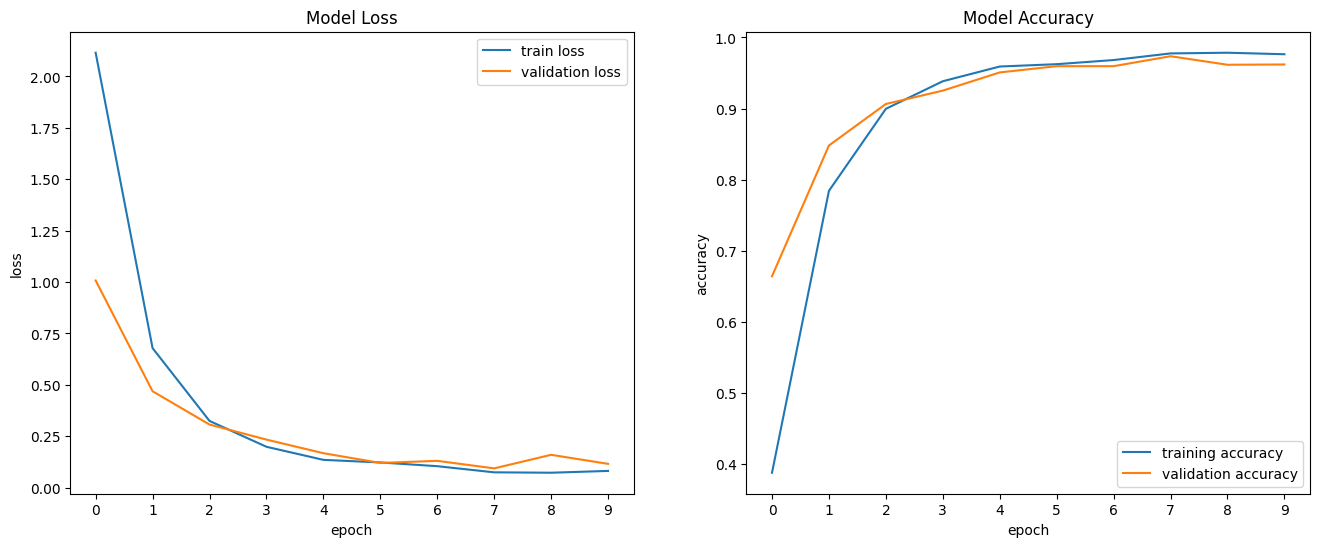

225/225 [==============================] - 10s 47ms/step - loss: 0.0816 - accuracy: 0.9764 - val_loss: 0.1161 - val_accuracy: 0.9620


In [71]:
# model training

num_epochs = 10

# Create an instance of our callback functions class, to plot our loss function and accuracy with each epoch.
pltCallBack = PlotLossAccuracy()

# Run the training.
model_1B.fit(X_train, Y_train,
          batch_size=100, epochs=num_epochs,
          validation_data=(X_validation, Y_validation),
          callbacks=[pltCallBack])

In [72]:
# Task 1B: Digit Classisation on Waveforms

# Construct your neural networks here


save_model_to_disk(model_1B, 'waveform_digit_model')

Saved model to waveform_digit_model.json and weights to waveform_digit_model.h5


In [18]:
spectrogram_dataset = np.zeros((x.shape[0], 128, 128))
for i in range(x.shape[0]):
  f, t, Zxx = scipy.signal.stft(x[i], 8000, nperseg=455, noverlap=393, window='hann')
  Zxx_ = np.abs(Zxx[0:227, 2:-1])
  Zxx_ = np.atleast_3d(Zxx_).transpose(2,0,1)
  # after the STFT, the spectrogram is simply computed by taking the amplitude of the Fourier coefficients.
  Zxx_ = librosa.amplitude_to_db(Zxx_, ref=np.max)
  Zxx_ = resize(Zxx_, (1,128, 128))
  spectrogram_dataset[i, :, :] = Zxx_

In [19]:
# check the result of pre processing
print("Array shape:", spectrogram_dataset.shape)

Array shape: (25000, 128, 128)


In [20]:
# save the stft result to drive for saving RAM resource
np.save('C:/Users/lic9/Desktop/pynb/data/spectrogram_dataset2.npy', spectrogram_dataset)

In [73]:
X = np.load('C:/Users/lic9/Desktop/pynb/data/spectrogram_dataset2.npy')

In [74]:
#X = spectrogram_dataset
Y = y_gender
X_train, X_validation, Y_train, Y_validation = skl.model_selection.train_test_split(X, Y, test_size=.1)

print("Array shape:\n", X_train.shape)
print("Array shape:\n", Y_train.shape)
print("Array shape:\n", X_validation.shape)
print("Array shape:\n", Y_validation.shape)





Array shape:
 (22500, 128, 128)
Array shape:
 (22500,)
Array shape:
 (2500, 128, 128)
Array shape:
 (2500,)


0


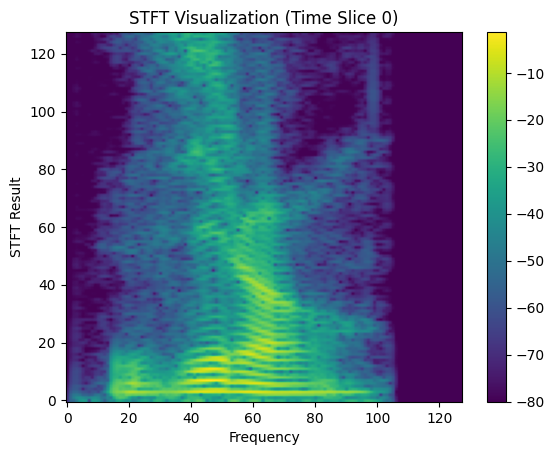

1


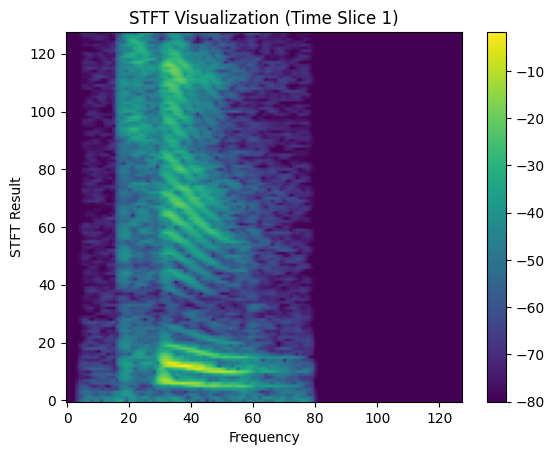

0


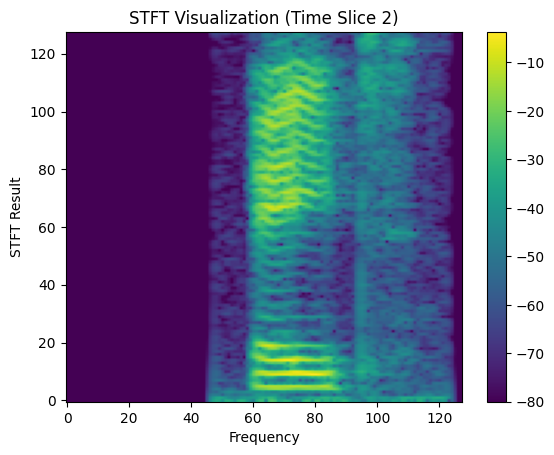

0


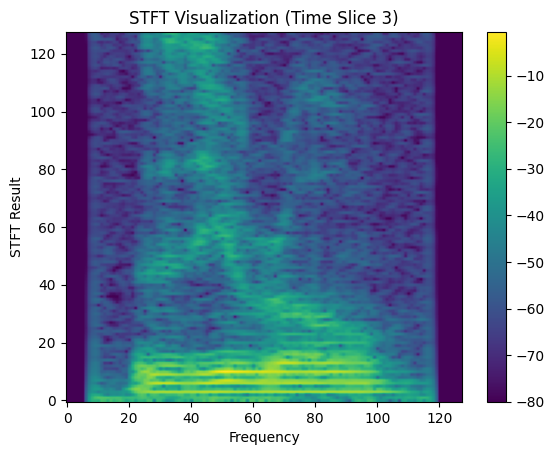

0


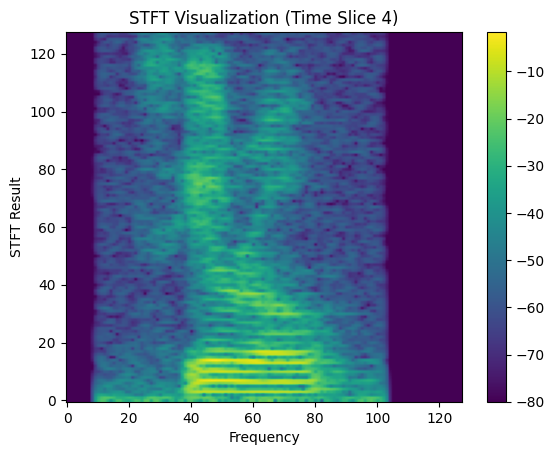

0


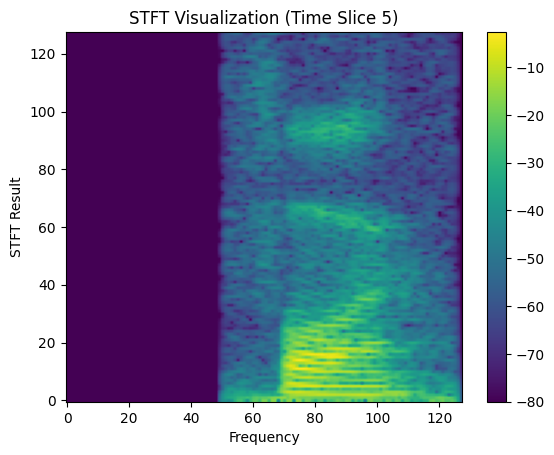

0


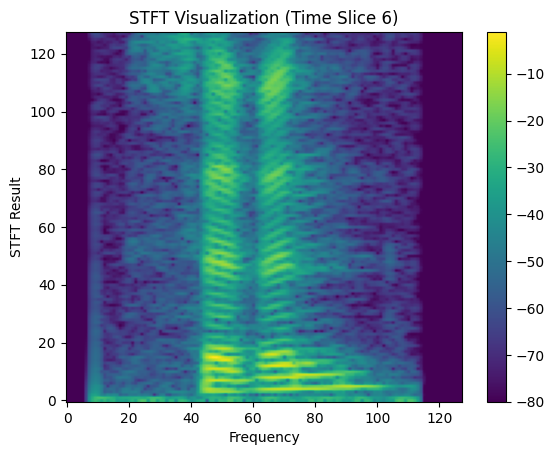

1


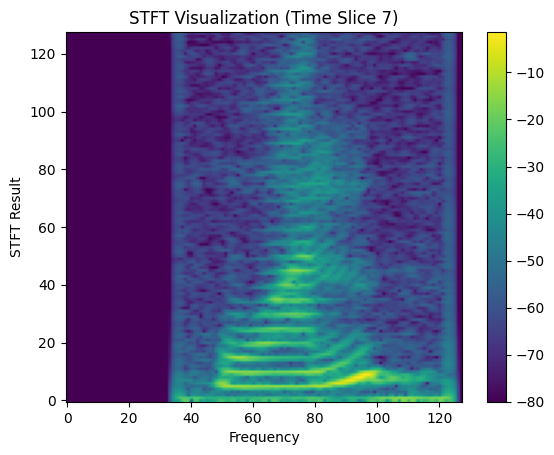

0


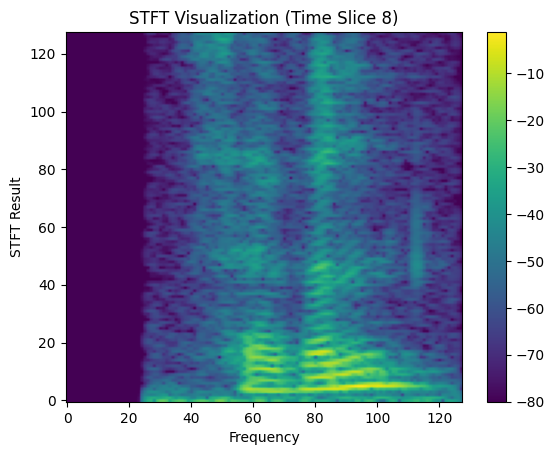

0


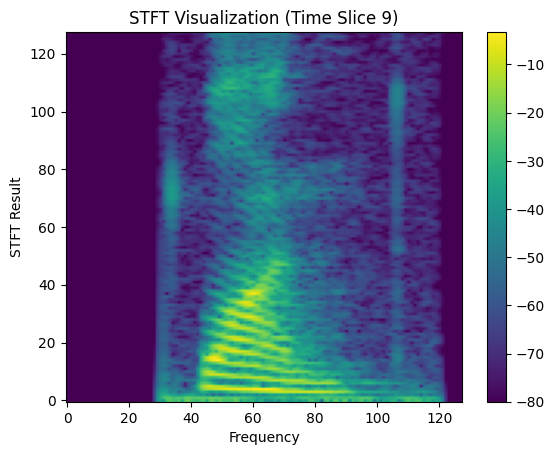

In [75]:
for time_slice in range(10):
    #time_slice = 200
    stft_data = X_train
    # Extract the 2D slice from the 4D data
    stft_slice = stft_data[time_slice, :, :]
    print(Y_train[time_slice])

    # Create a 2D plot
    plt.imshow(stft_slice, cmap='viridis', aspect='auto', origin='lower')

    # Add labels and title
    plt.xlabel('Frequency')
    plt.ylabel('STFT Result')
    plt.title('STFT Visualization (Time Slice {})'.format(time_slice))

    # Show the colorbar for reference
    plt.colorbar()

    # Show the plot
    plt.show()

In [78]:
# Alex net
# define model



def build_model():
  inputs = keras.layers.Input(shape=(128, 128, 1))
  x = inputs
  x = keras.layers.Conv2D(54, (11,11), activation = 'relu', padding = 'same')(x)
  x = keras.layers.MaxPooling2D((5,5), strides=(4,4))(x)
  x = keras.layers.Dropout(.3)(x)
  x = keras.layers.Conv2D(72, (5,5), activation = 'relu', padding = 'same')(x)
  x = keras.layers.MaxPooling2D((3,3), strides=(4,4))(x)
  x = keras.layers.Dropout(.3)(x)

  # x = keras.layers.Conv2D(384, (3,3), activation = 'relu', padding = 'same')(x)
  # x = keras.layers.Dropout(.3)(x)
  x = keras.layers.Conv2D(108, (3,3), activation = 'relu', padding = 'same')(x)
  x = keras.layers.Dropout(.3)(x)
  x = keras.layers.Conv2D(72, (3,3), activation = 'relu', padding = 'same')(x)
  x = keras.layers.MaxPooling2D((3,3), strides=(4,4))(x)
  x = keras.layers.Dropout(.3)(x)

  x = keras.layers.Flatten()(x)
  x = keras.layers.Dense(32, activation='relu', bias_regularizer = keras.regularizers.L2())(x)
  x = keras.layers.Dense(32, activation='relu', bias_regularizer = keras.regularizers.L2())(x)
  x = keras.layers.Dense(16, activation='relu', bias_regularizer = keras.regularizers.L2())(x)
  output = keras.layers.Dense(2, activation='sigmoid', name="output")(x)

  # Create the model.
  model = keras.models.Model(inputs=inputs, outputs=output)
  opt = keras.optimizers.legacy.SGD(learning_rate=0.01, decay=1e-6, momentum=0.9, nesterov=True)

  # Setup the optimisation strategy.
  model.compile(optimizer="Adam",
                loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])


  return model
# optimizer="Adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"]

# Get the model
model_2A = build_model()

# changhong: for this scene, we dont need to tackle continuous voice , RNN is useless so dercease rnn_units

model_2A.summary(line_length=110)

Model: "model_19"
______________________________________________________________________________________________________________
 Layer (type)                                    Output Shape                                Param #          
 input_9 (InputLayer)                            [(None, 128, 128, 1)]                       0                
                                                                                                              
 conv2d_43 (Conv2D)                              (None, 128, 128, 54)                        6588             
                                                                                                              
 max_pooling2d_30 (MaxPooling2D)                 (None, 31, 31, 54)                          0                
                                                                                                              
 dropout_43 (Dropout)                            (None, 31, 31, 54)                          0

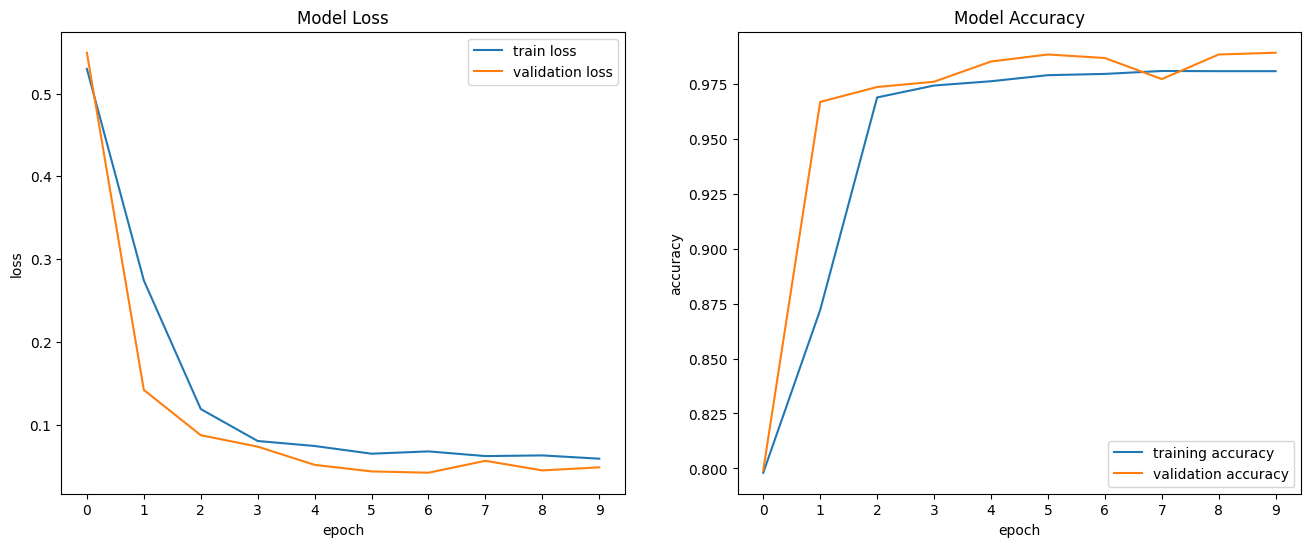

563/563 [==============================] - 10s 19ms/step - loss: 0.0588 - accuracy: 0.9808 - val_loss: 0.0484 - val_accuracy: 0.9892


In [79]:
# model training


num_epochs = 10

# Create an instance of our callback functions class, to plot our loss function and accuracy with each epoch.
pltCallBack = PlotLossAccuracy()

# Run the training.
with tf.device('/GPU:1'):
    model_2A.fit(X_train, Y_train,
          batch_size=40, epochs=num_epochs,
          validation_data=(X_validation, Y_validation),
          callbacks=[pltCallBack])

In [80]:
if tf.test.gpu_device_name():
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))
else:
    print("Please install GPU version of TF")
print("NUM OF GPU = ", len(tf.config.experimental.list_physical_devices('GPU')))

Default GPU Device: /device:GPU:0
NUM OF GPU =  1


In [81]:
# Task 2A: Gender Classisation on Spectrograms
# first you'll need to convert all waveforms to spectrogram (see sample code in prev cell)

# Construct your neural networks here


save_model_to_disk(model_2A, 'spectrogram_gender_model')

Saved model to spectrogram_gender_model.json and weights to spectrogram_gender_model.h5


In [82]:
# Task 2B: div dataset
X = np.load('C:/Users/lic9/Desktop/pynb/data/spectrogram_dataset2.npy')

In [83]:
Y = y_num
X_train, X_validation, Y_train, Y_validation = skl.model_selection.train_test_split(X, Y, test_size=.1)

print("Array shape:\n", X_train.shape)
print("Array shape:\n", Y_train.shape)
print("Array shape:\n", X_validation.shape)
print("Array shape:\n", Y_validation.shape)

for i in range(1,10):
    print(Y_train[i])

Array shape:
 (22500, 128, 128)
Array shape:
 (22500,)
Array shape:
 (2500, 128, 128)
Array shape:
 (2500,)
7
5
8
4
7
0
9
6
9


5


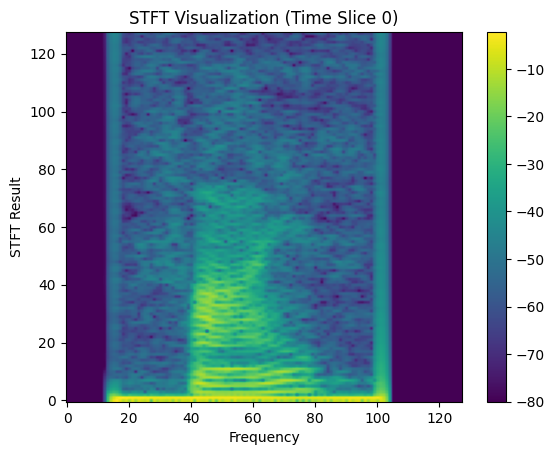

7


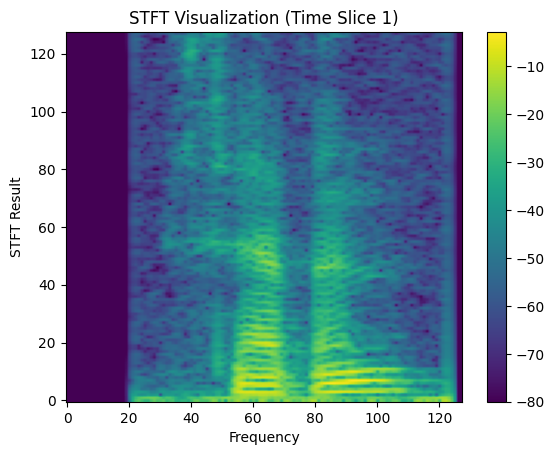

5


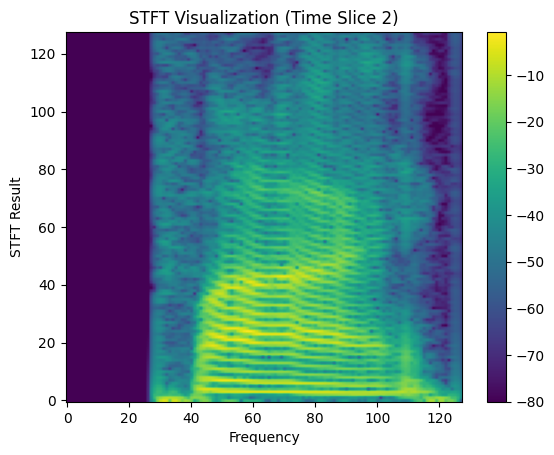

8


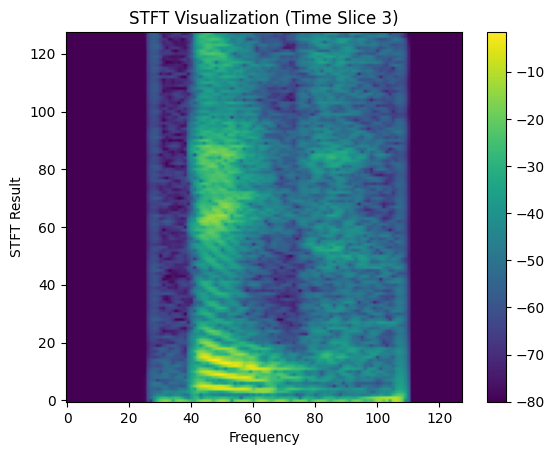

4


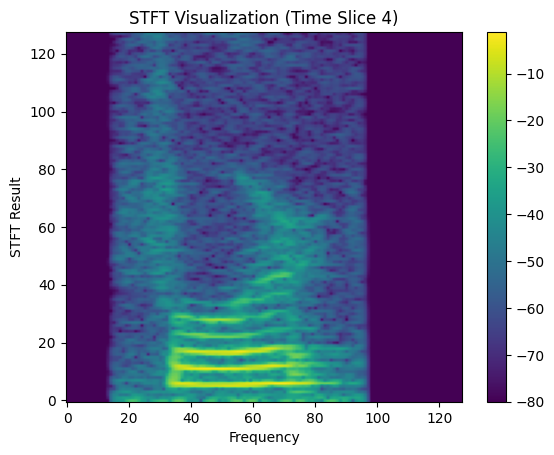

7


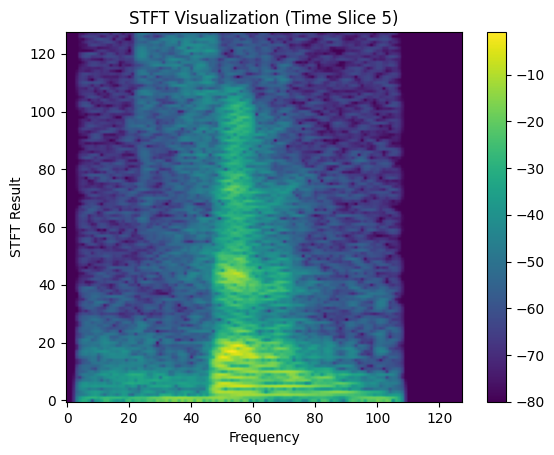

0


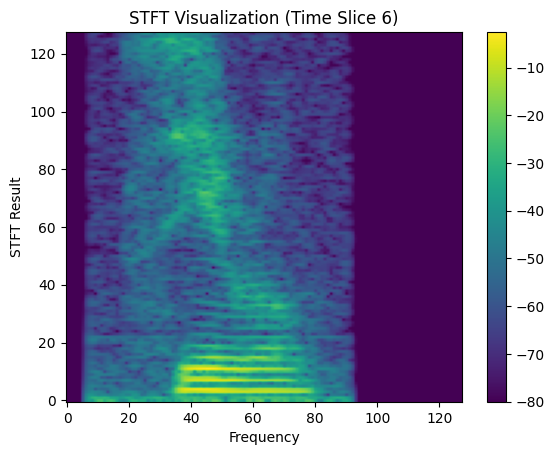

9


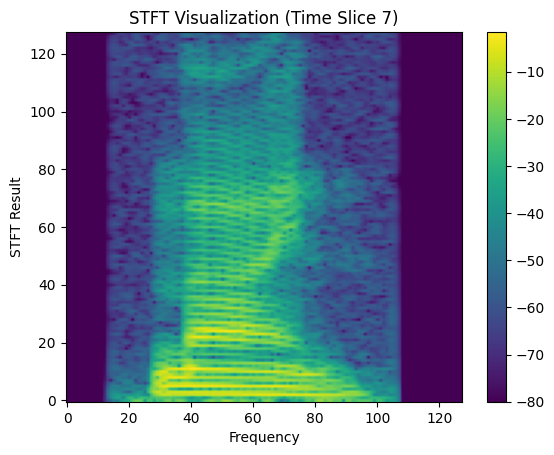

6


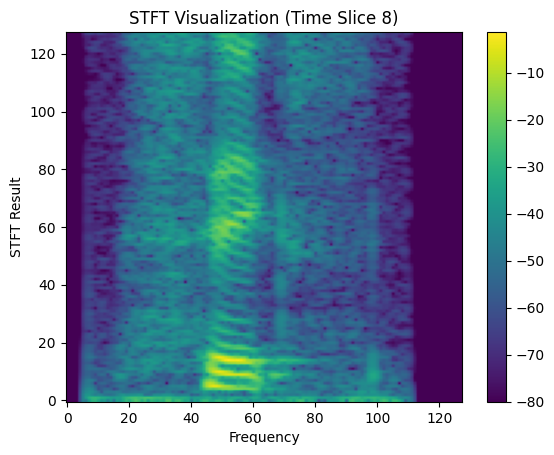

9


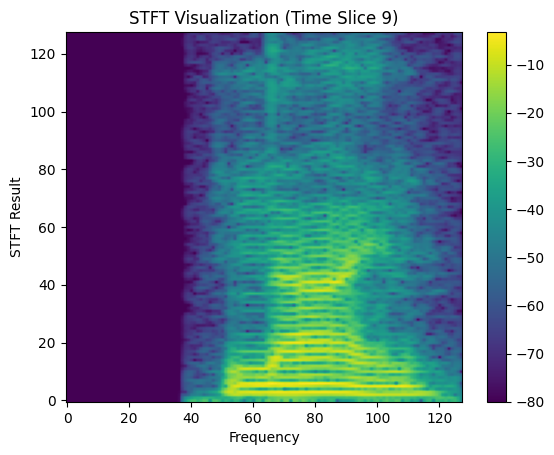

In [84]:
for time_slice in range(10):
    #time_slice = 200
    stft_data = X_train
    # Extract the 2D slice from the 4D data
    stft_slice = stft_data[time_slice, :, :]
    print(Y_train[time_slice])

    # Create a 2D plot
    plt.imshow(stft_slice, cmap='viridis', aspect='auto', origin='lower')

    # Add labels and title
    plt.xlabel('Frequency')
    plt.ylabel('STFT Result')
    plt.title('STFT Visualization (Time Slice {})'.format(time_slice))

    # Show the colorbar for reference
    plt.colorbar()

    # Show the plot
    plt.show()

Array shape:
 (22500, 128, 128)
Array shape:
 (22500,)
Array shape:
 (2500, 128, 128)
Array shape:
 (2500,)
9


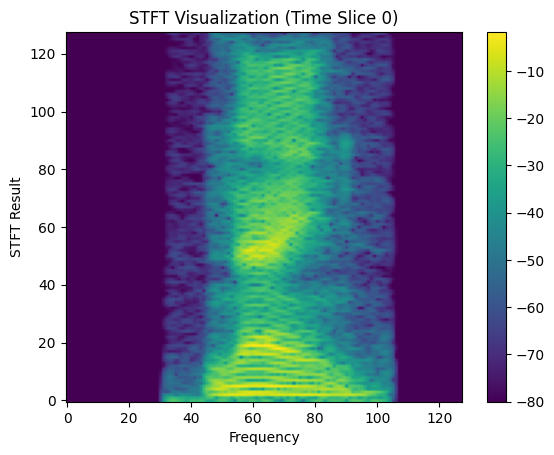

3


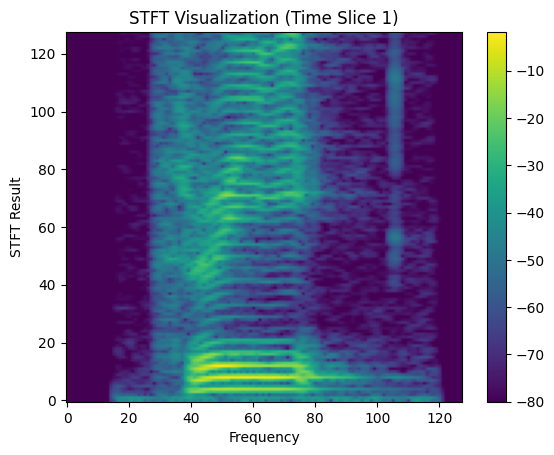

4


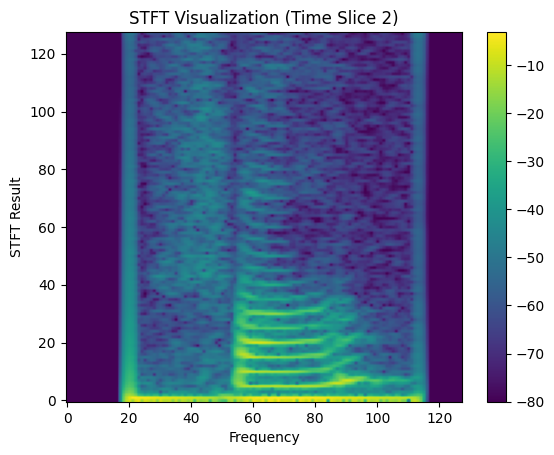

6


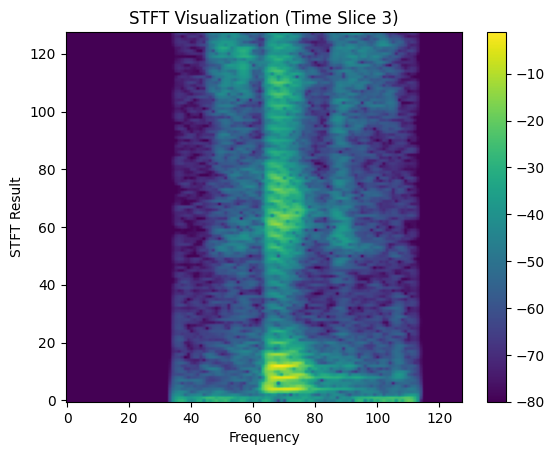

4


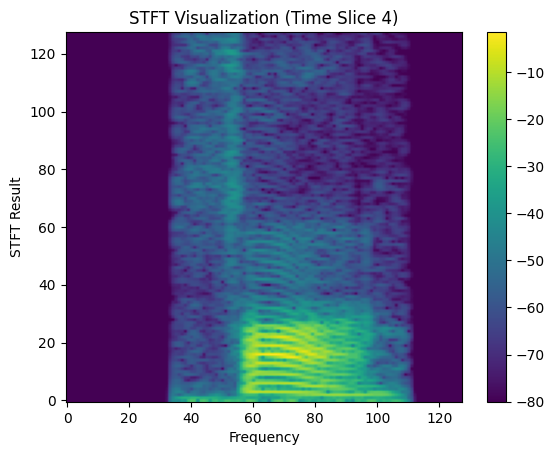

7


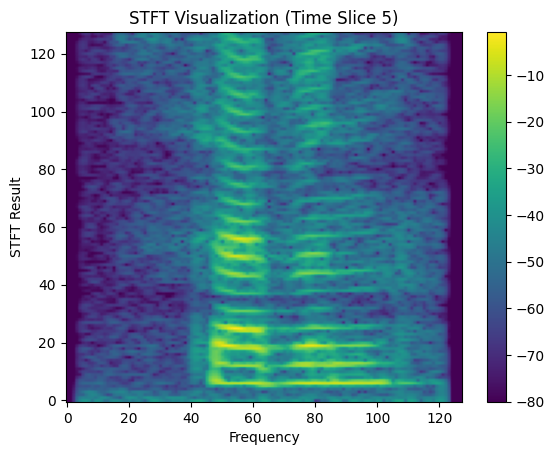

7


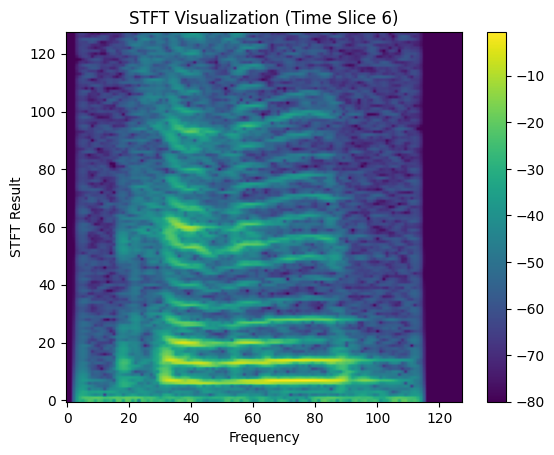

2


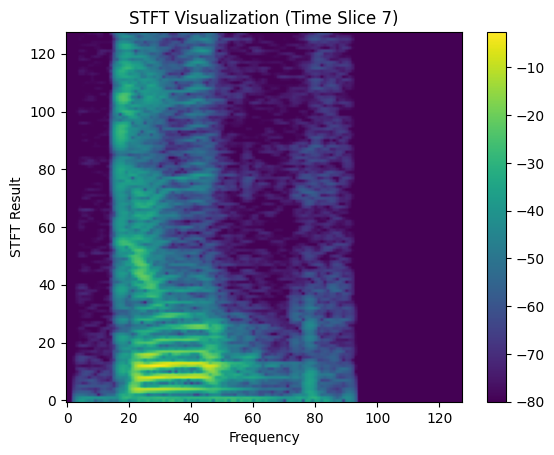

5


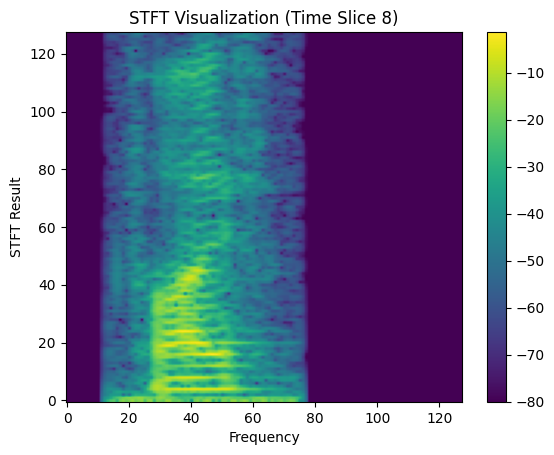

9


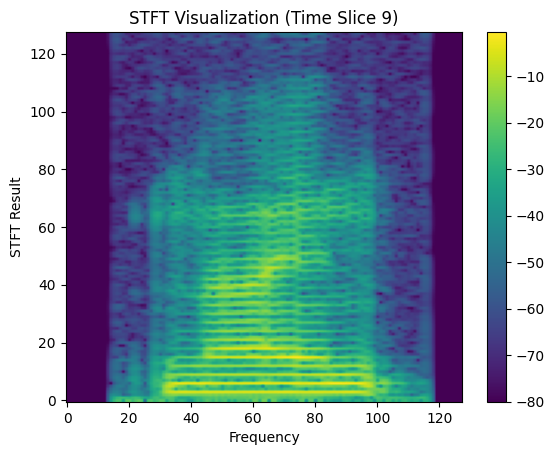

In [85]:
X = np.load('C:/Users/lic9/Desktop/pynb/data/spectrogram_dataset2.npy')
Y = y_num
X_train, X_validation, Y_train, Y_validation = skl.model_selection.train_test_split(X, Y, test_size=.1)
print("Array shape:\n", X_train.shape)
print("Array shape:\n", Y_train.shape)
print("Array shape:\n", X_validation.shape)
print("Array shape:\n", Y_validation.shape)
for time_slice in range(10):
    #time_slice = 200
    stft_data = X_train
    # Extract the 2D slice from the 4D data
    stft_slice = stft_data[time_slice, :, :]
    print(Y_train[time_slice])

    # Create a 2D plot
    plt.imshow(stft_slice, cmap='viridis', aspect='auto', origin='lower')

    # Add labels and title
    plt.xlabel('Frequency')
    plt.ylabel('STFT Result')
    plt.title('STFT Visualization (Time Slice {})'.format(time_slice))

    # Show the colorbar for reference
    plt.colorbar()

    # Show the plot
    plt.show()

In [86]:
CLASS_NUMS = 10;

def build_model(input_shape, num_classes):
    inputs = keras.layers.Input(shape=input_shape, name="input")
    
    x = inputs
    x = keras.layers.Conv2D(54, (11,11), activation = 'relu', padding = 'same')(x)
    x = keras.layers.MaxPooling2D((5,5), strides=(4,4))(x)
    x = keras.layers.Dropout(.3)(x)
    x = keras.layers.Conv2D(72, (5,5), activation = 'relu', padding = 'same')(x)
    x = keras.layers.MaxPooling2D((3,3), strides=(4,4))(x)
    x = keras.layers.Dropout(.3)(x) 
    #x = keras.layers.Conv2D(384, (3,3), activation = 'relu', padding = 'same')(x)
    #x = keras.layers.Dropout(.3)(x)
    x = keras.layers.Conv2D(108, (3,3), activation = 'relu', padding = 'same')(x)
    x = keras.layers.Dropout(.3)(x)
    x = keras.layers.Conv2D(72, (3,3), activation = 'relu', padding = 'same')(x)
    x = keras.layers.MaxPooling2D((3,3), strides=(4,4))(x)
    x = keras.layers.Dropout(.3)(x) 
    x = keras.layers.Flatten()(x)
    x = keras.layers.Dense(32, activation='relu', bias_regularizer = keras.regularizers.L2())(x)
    x = keras.layers.Dense(32, activation='relu', bias_regularizer = keras.regularizers.L2())(x)
    x = keras.layers.Dense(16, activation='relu', bias_regularizer = keras.regularizers.L2())(x)

    outputs = keras.layers.Dense(num_classes, activation="softmax", name="output")(x)

    return keras.models.Model(inputs=inputs, outputs=outputs)


#model = build_model((SAMPLING_RATE // 2, 1), len(class_names))
model2B = build_model((128,128 , 1), CLASS_NUMS)


model2B.summary()

# Compile the model using Adam's default learning rate
model2B.compile(
    optimizer="Adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"]
)

Model: "model_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 128, 128, 1)]     0         
                                                                 
 conv2d_47 (Conv2D)          (None, 128, 128, 54)      6588      
                                                                 
 max_pooling2d_33 (MaxPoolin  (None, 31, 31, 54)       0         
 g2D)                                                            
                                                                 
 dropout_47 (Dropout)        (None, 31, 31, 54)        0         
                                                                 
 conv2d_48 (Conv2D)          (None, 31, 31, 72)        97272     
                                                                 
 max_pooling2d_34 (MaxPoolin  (None, 8, 8, 72)         0         
 g2D)                                                     

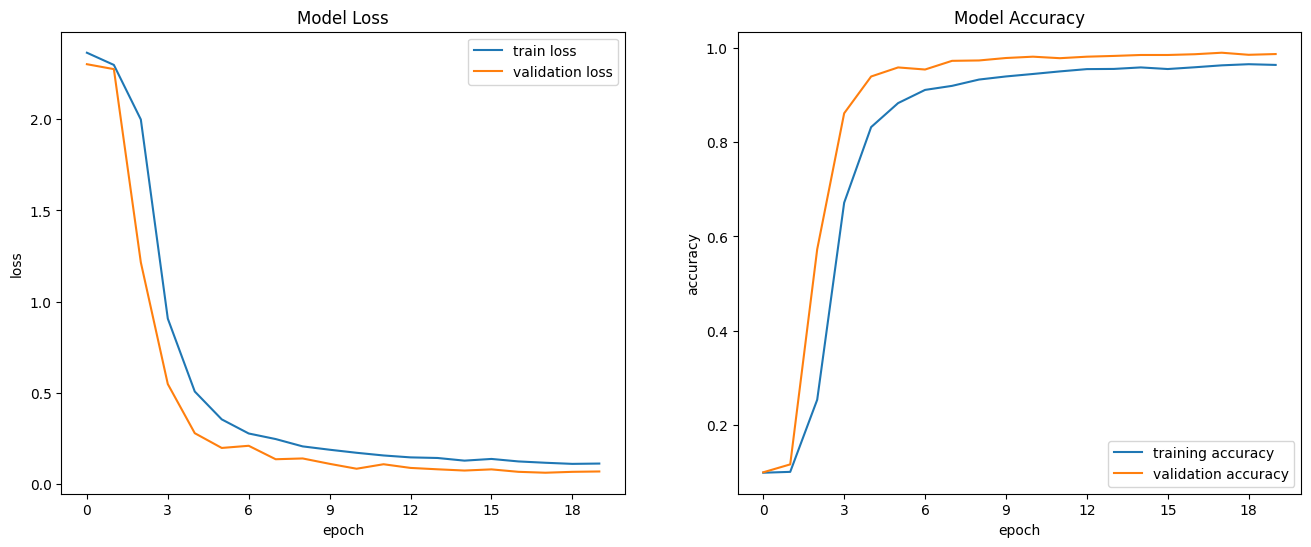

225/225 [==============================] - 8s 37ms/step - loss: 0.1107 - accuracy: 0.9637 - val_loss: 0.0673 - val_accuracy: 0.9868


In [87]:
# model training


num_epochs = 20

# Create an instance of our callback functions class, to plot our loss function and accuracy with each epoch.
pltCallBack = PlotLossAccuracy()

# Run the training.
with tf.device('/GPU:1'):
    model2B.fit(X_train, Y_train,
          batch_size=100, epochs=num_epochs,
          validation_data=(X_validation, Y_validation),
          callbacks=[pltCallBack])

In [88]:
# Task 2B: Digit Classisation on Spectrograms
# first you'll need to convert all waveforms to spectrogram (see sample code in prev cell)

# Construct your neural networks here

model_2B = model2B# Figure this out
save_model_to_disk(model_2B, 'spectrogram_digit_model')

Saved model to spectrogram_digit_model.json and weights to spectrogram_digit_model.h5
